In [1]:
import time
notebook_start_time = time.time()

- converting Meta AI's Llama 2 architecture model step by step to Llama 3, Llama 3.1, and Llama 3.2





- the Llama 2 paper: [Llama 2: Open Foundation and Fine-Tuned Chat Models (2023)](https://arxiv.org/abs/2307.09288)

- the Llama 3 paper: [The Llama 3 Herd of Models](https://arxiv.org/abs/2407.21783)

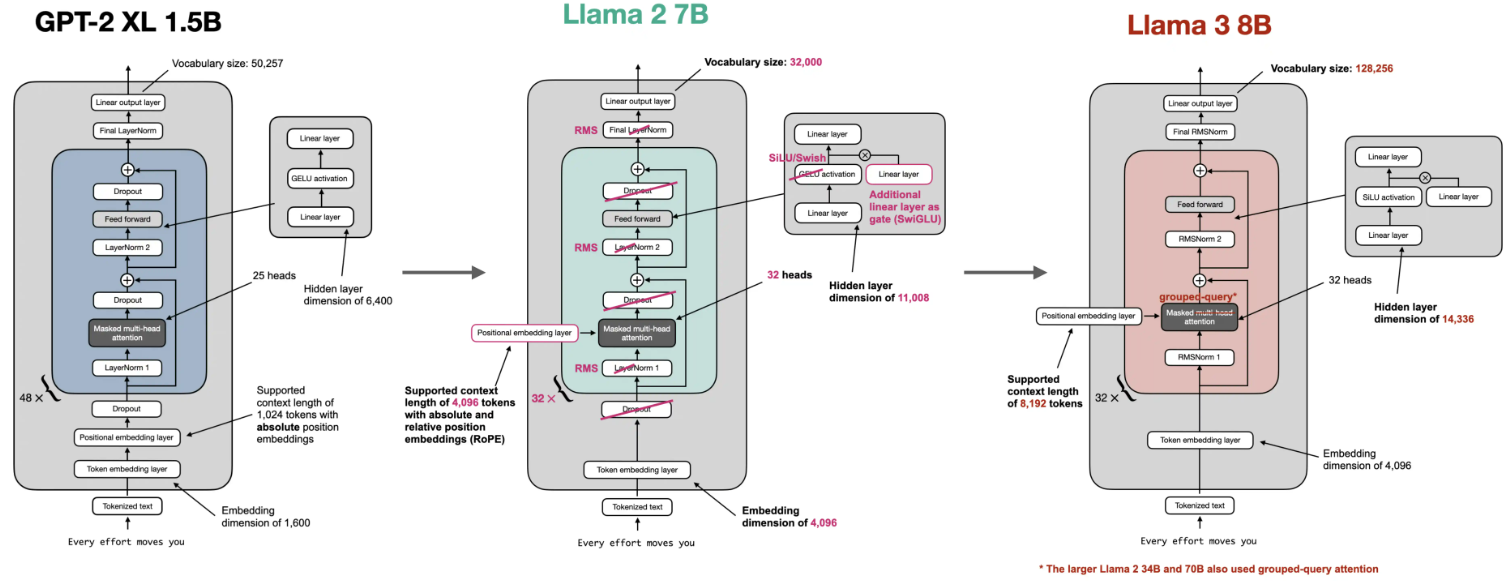

# 0. Setup

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
from importlib.metadata import version

pkgs = [
    "blobfile",         # to download pretrained weights
    "huggingface_hub",  # to download pretrained weights
    "tiktoken",         # to implement the tokenizer
    "torch",            # to implement the model
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

blobfile version: 3.0.0
huggingface_hub version: 0.33.0
tiktoken version: 0.9.0
torch version: 2.6.0+cu124


# 1. Convert the Llama model implementation step-by-step

- `gpt2_to_llama2.ipunb` implements the Llama-specific components, such as RMSNorm layers, SiLU and SwiGLU activations, RoPE, and the SentencePiece tokenizer

- This notebook takes the Llama 2 architecture and transforms it into Llama 3 architecture by:
  1. modifying the rotary embeddings
  2. implementing grouped-query attention
  3. and using a customized version of the GPT-4 tokenizer

- Later, we then load the original Llama 3 weights shared by Meta AI into the architecture

## 1.1 Reusing Llama2 components

In [4]:
import torch
import torch.nn as nn


# We need to redefine precompute_rope_params
# def precompute_rope_params(head_dim,
#                            theta_base=10_000,
#                            context_length=4096):
#   assert head_dim % 2 == 0, "Embedding dimension must be even"

#   # (Eq. 1) compute the inverse frequencies
#   # theta_i = 10000 ^ (-2(i-1)/dim) for i = 1, 2, ..., dim/2
#   inv_freq = 1.0 / (
#       theta_base ** (torch.arange(0, head_dim, 2).float() / head_dim))

#   # generate position indices
#   positions = torch.arange(context_length)

#   # compute the angles
#   # positions -> row vector
#   # inv_freq -> column vector
#   angles = positions[:, None] * inv_freq[None, :] # (context_length, head_dim // 2)

#   # expand angles to match the head_dim
#   angles = torch.cat([angles, angles], dim=1) # (context_length, head_dim)

#   # precompute sine and cosine
#   cos = torch.cos(angles)
#   sin = torch.sin(angles)

#   return cos, sin


def compute_rope(x, cos, sin):
  # x -> (batch_size, num_heads, seq_len, head_dim)
  batch_size, num_heads, seq_len, head_dim = x.shape
  assert head_dim % 2 == 0, "Embedding dimension must be even"

  # split x into two subspaces
  x1 = x[..., :head_dim // 2] # first half
  x2 = x[..., head_dim // 2 :] # second half

  # adjust sin and cos shapes
  cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, head_dim)
  sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

  # apply the rotary transformation
  rotated = torch.cat((-x2, x1), dim=-1)
  x_rotated = (x * cos) + (rotated * sin)

  return x_rotated.to(dtype=x.dtype)


class SiLU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return x * torch.sigmoid(x)


class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.silu = SiLU()
    self.fc1 = nn.Linear(config["emb_dim"],
                         config["hidden_dim"],
                         dtype=config["dtype"],
                         bias=False)
    self.fc2 = nn.Linear(config["emb_dim"],
                         config["hidden_dim"],
                         dtype=config["dtype"],
                         bias=False)
    self.fc3 = nn.Linear(config["hidden_dim"],
                         config["emb_dim"],
                         dtype=config["dtype"],
                         bias=False)

  def forward(self, x):
    x_fc1 = self.fc1(x)
    x_silu = self.silu(x_fc1)
    x_fc2 = self.fc2(x)
    x_swiglu = x_silu * x_fc2
    return self.fc3(x_swiglu)


class RMSNorm(nn.Module):
  def __init__(self, emb_dim, eps=1e-5):
    super().__init__()
    self.eps = eps
    self.emb_dim = emb_dim
    self.weight = nn.Parameter(torch.ones(emb_dim)).float()

  def forward(self, x):
    means = x.pow(2).mean(dim=-1, keepdim=True)
    x_normed = (x *
                torch.rsqrt(means + self.eps) # reciprocal of the square root
                )
    return (x_normed * self.weight).to(dtype=x.dtype)


# MultiHeadAttention only for comparison purposes
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 input_embedding_dim,
                 output_embedding_dim,
                 context_length,
                 #dropout,
                 num_heads,
                 #qkv_bias=False,
                 dtype=None):
        super().__init__()
        assert (output_embedding_dim % num_heads == 0), \
            "output_embedding_dim must be divisible by num_heads"

        self.output_embedding_dim = output_embedding_dim
        self.num_heads = num_heads
        self.head_dim = output_embedding_dim // num_heads

        ################################### NEW ###################################
        # Set bias=False and dtype=dtype for all linear layers below
        ###########################################################################
        self.W_query = nn.Linear(input_embedding_dim,
                                 output_embedding_dim,
                                 bias=False,
                                 dtype=dtype)
        self.W_key = nn.Linear(input_embedding_dim,
                               output_embedding_dim,
                               bias=False,
                               dtype=dtype)
        self.W_value = nn.Linear(input_embedding_dim,
                                 output_embedding_dim,
                                 bias=False,
                                 dtype=dtype)
        self.output_projection = nn.Linear(output_embedding_dim,
                                           output_embedding_dim,
                                           bias=False,
                                           dtype=dtype)  # to combine head outputs
        # self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1))

        ################################### NEW ###################################
        cos, sin = precompute_rope_params(head_dim=self.head_dim,
                                          context_length=context_length)
        self.register_buffer("cos", cos)
        self.register_buffer("sin", sin)
        ###########################################################################

    def forward(self, inputs):
        batch, num_tokens, input_embedding_dim = inputs.shape

        # qkv shapes : (batch, num_tokens, output_embedding_dim)
        keys = self.W_key(inputs)
        values = self.W_value(inputs)
        queries = self.W_query(inputs)

        # qkv shapes : (batch, num_tokens, num_heads, head_dim)
        keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)

        # qkv shapes : (batch, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        ################################### NEW ###################################
        keys = compute_rope(keys, self.cos, self.sin)
        queries = compute_rope(queries, self.cos, self.sin)
        ###########################################################################

        # compute attention scores for each head
        attention_scores = queries @ keys.transpose(3, 2)
        attention_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], - torch.inf)

        # compute attention weights + dropout
        masked_attention_weight = torch.softmax(
            attention_scores / (keys.shape[-1] ** 0.5),
            dim=-1)
        # masked_attention_dropout_weight = self.dropout(masked_attention_weight)

        # compute context vectors
        # shape : (batch, num_tokens, num_heads, head_dim)
        #context_vector = (masked_attention_dropout_weight @ values).transpose(1, 2)
        context_vector = (masked_attention_weight @ values).transpose(1, 2)

        # combine heads, where self.d_out = self.num_heads * self.head_dim
        # shape : (batch, num_tokens, output_embedding_dim)
        context_vector = context_vector.contiguous().view(
            batch, num_tokens, self.output_embedding_dim)

        # linear projection (optional)
        context_vector = self.output_projection(context_vector)

        return context_vector

## 1.2 Modified RoPE

- Llama 3 also uses [RoPE](https://arxiv.org/abs/2104.09864)

- some subtle differences:
  1. supports up to 8,192 tokens, twice as many as Llama 2 (4,096)
  2. the base value for $\theta$ is now 500_000:
  $$
  \Theta = \left\{ \theta_i = \text{base}^{\frac{-2(i-1)}{d}} \quad  \middle| \quad i = 1,2,\cdots, d/2 \right\}
  $$
  where:
    - $\theta$: a set of predefined parameters that are used to determine the rotational angles in the rotary matrix
    - $d$: the dimensionality of the embedding space
  3. Increasing the base to 500_000 makes the frequencies (or rotation angles) decay more slowly across the dimensions, which means that higher dimensions will be associated with larger angles than before (essentially, it's a decompression of the frequencies)
  4. In addition, we introduce a `freq_config` section in the code below that adjusts the frequency; however, we won't be needing it in Llama 3 (only Llama 3.1 and Llama 3.2), so we will revisit this `freq_config` later (it's set to `None` and ignored by default)


In [5]:
def precompute_rope_params(head_dim,
                           theta_base=10_000,
                           context_length=4096,
                           freq_config=None):
  assert head_dim % 2 == 0, "Embedding dimension must be even"

  # (Eq. 1) compute the inverse frequencies
  # theta_i = 10000 ^ (-2(i-1)/dim) for i = 1, 2, ..., dim/2
  inv_freq = 1.0 / (
      theta_base ** (torch.arange(0, head_dim, 2).float() / head_dim))

  ################################ NEW ###############################################
  # Frequency adjustments
  if freq_config is not None:
    low_freq_wavelen = freq_config["original_context_length"] / freq_config["low_freq_factor"]
    high_freq_wavelen = freq_config["original_context_length"] / freq_config["high_freq_factor"]

    wavelen = 2 * torch.pi / inv_freq

    inv_freq_llama = torch.where(
        wavelen > low_freq_wavelen,
        inv_freq / freq_config["factor"],
        inv_freq
    )

    smooth_factor = (freq_config["original_context_length"] / wavelen - freq_config["low_freq_factor"]) / (
        freq_config["high_freq_factor"] - freq_config["low_freq_factor"]
    )

    smooth_inv_freq = (
        (1 - smooth_factor) * (inv_freq / freq_config["factor"]) + smooth_factor * inv_freq
    )

    is_medium_freq = (wavelen <= low_freq_wavelen) & (wavelen >= high_freq_wavelen)
    inv_freq_llama = torch.where(is_medium_freq,
                                 smooth_inv_freq,
                                 inv_freq_llama)
    inv_freq = inv_freq_llama
  ####################################################################################


  # generate position indices
  positions = torch.arange(context_length)

  # compute the angles
  # positions -> row vector
  # inv_freq -> column vector
  angles = positions[:, None] * inv_freq[None, :] # (context_length, head_dim // 2)

  # expand angles to match the head_dim
  angles = torch.cat([angles, angles], dim=1) # (context_length, head_dim)

  # precompute sine and cosine
  cos = torch.cos(angles)
  sin = torch.sin(angles)

  return cos, sin

- To summarize, what's new so far for Llama 3 compared to Llama 2 are the context length and theta base parameter:

In [6]:
# Instantiate RoPE parameters

llama_2_context_len = 4096
llama_3_context_len = 8192

llama_2_theta_base = 10_000
llama_3_theta_base = 500_000

- the usage remains the same as before in Llama2:

In [7]:
# example
batch_size = 2
num_heads = 4
head_dim = 16

# Instantiate RoPE parameters
cos, sin = precompute_rope_params(
    head_dim=head_dim,
    theta_base=llama_3_theta_base,
    context_length=llama_3_context_len
)

# Dummy query and key tensors
torch.manual_seed(123)
queries = torch.randn(batch_size, num_heads, llama_3_context_len, head_dim)
keys = torch.randn(batch_size, num_heads, llama_3_context_len, head_dim)

# Apply rotary position embeddings
queries_rot = compute_rope(queries, cos, sin)
keys_rot = compute_rope(keys, cos, sin)

# 1.3 Group-Query Attention (QGA)

- we replace `MHA` with `GQA` mechanism, which is a more compute- and parameter-efficient version of `MHA`

- `GQA` reduce the number of key and value projections by sharing them among multiple attention heads. Each head still has its unique query, but these queries attend to the same group of keys and values

- Example: `GQA` with 2 key-value-groups (kv-groups):

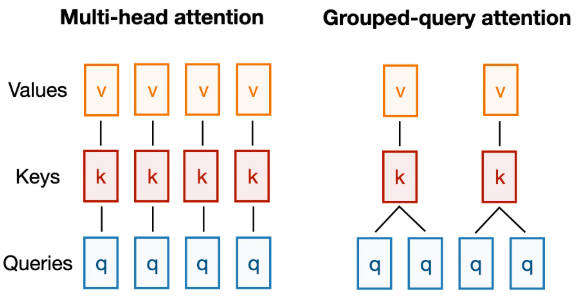


- `GQA` main idea: reduce the number of unique query groups that attend to the key-value pairs, reducing the size of some of the matrix multiplications and the number of parameters in MHA without significantly reducing modeling performance

- the main change in GQA is that each query group needs to be repeated to match the number of heads it is associated with

- We also redesign the attention class a bit so it receives the mask through its forward method instead of storing and accessing it as `self.mask`. This lets us build the mask on the fly to reduce memory usage. To foreshadow why: Llama 3.1 can handle sequences of up to 128 k tokens, and precomputing a 128 k × 128 k causal mask would be extremely memory‑intensive, so we avoid it unless absolutely necessary.

- side note: `GQA` is equivalent to `MHA` when `num_kv_groups = num_heads`

In [8]:
import torch.nn as nn

class GroupedQueryAttention(nn.Module):
  def __init__(
      self,
      input_embedding_dim,
      output_embedding_dim,
      num_heads,
      num_kv_groups,
      dtype=None,
      ):
    super().__init__()
    assert output_embedding_dim % num_heads == 0, "output_embedding_dim must be divisible by num_heads"
    assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

    self.output_embedding_dim = output_embedding_dim
    self.num_heads = num_heads
    self.head_dim = output_embedding_dim // num_heads


    ################################### NEW ###################################
    # self.W_query = nn.Linear(input_embedding_dim,
    #                           output_embedding_dim,
    #                           bias=False,
    #                           dtype=dtype)
    # self.W_key = nn.Linear(input_embedding_dim,
    #                         output_embedding_dim,
    #                         bias=False,
    #                         dtype=dtype)
    self.W_key = nn.Linear(input_embedding_dim,
                           num_kv_groups * self.head_dim,
                           bias=False,
                           dtype=dtype)
    self.W_value = nn.Linear(input_embedding_dim,
                           num_kv_groups * self.head_dim,
                           bias=False,
                           dtype=dtype)
    self.num_kv_groups = num_kv_groups
    self.group_size = num_heads // num_kv_groups
    ###########################################################################

    self.W_query = nn.Linear(input_embedding_dim,
                            output_embedding_dim,
                            bias=False,
                            dtype=dtype)
    self.output_projection = nn.Linear(output_embedding_dim,
                                        output_embedding_dim,
                                        bias=False,
                                        dtype=dtype) # to combine head outputs
    # self.dropout = nn.Dropout(dropout)
    # self.register_buffer(
    #     "mask",
    #     torch.triu(torch.ones(context_length, context_length),
    #                 diagonal=1))


    # cos, sin = precompute_rope_params(head_dim=self.head_dim,
    #                                       context_length=context_length)
    # self.register_buffer("cos", cos)
    # self.register_buffer("sin", sin)

  def forward(self,
              inputs,
              mask=None,
              cos=None,
              sin=None):
    ##################### NEW  #####################
    # The forward method now accepts `mask` instead of accessing it via self.mask.
    # Also, we now have cos and sin as input for RoPE
    ################################################
    batch, num_tokens, input_embedding_dim = inputs.shape

    # qkv shapes : (batch, num_tokens, output_embedding_dim)
    keys = self.W_key(inputs)
    values = self.W_value(inputs)
    queries = self.W_query(inputs)

    ##################### NEW  #####################
    # keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
    # values = values.view(batch, num_tokens, self.num_heads, self.head_dim)
    # kv shapes : (batch, num_tokens, num_kv_groups, head_dim)
    keys = keys.view(batch, num_tokens, self.num_kv_groups, self.head_dim)
    values = values.view(batch, num_tokens, self.num_kv_groups, self.head_dim)
    ################################################
    # q shape : (batch, num_tokens, num_heads, head_dim)
    queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)

    # kv shapes : (batch, num_kv_groups, num_tokens, head_dim)
    # q shape : (batch, num_heads, num_tokens, head_dim)
    keys = keys.transpose(1, 2)
    values = values.transpose(1, 2)
    queries = queries.transpose(1, 2)

    ##################### NEW #####################
    # keys = compute_rope(keys, self.cos, self.sin)
    # queries = compute_rope(queries, self.cos, self.sin)
    # Apply RoPE
    if cos is not None:
      keys = compute_rope(keys, cos, sin)
      queries = compute_rope(queries, cos, sin)
    ##############################################

    ##################### NEW  #####################
    # Expand keys and values to match the number of heads
    # kv shapes : (batch, num_heads, num_tokens, head_dim)
    keys = keys.repeat_interleave(self.group_size, dim=1)
    values = values.repeat_interleave(self.group_size, dim=1)
    # For example, before repeat_interleave along dim=1 (query groups):
    #   [K1, K2]
    # After repeat_interleave (each query group is repeated group_size times):
    #   [K1, K1, K2, K2]
    # If we used regular repeat instead of repeat_interleave, we'd get:
    #   [K1, K2, K1, K2]
    ################################################

    # compute attention scores for each head with a causal mask
    # shape : (batch, num_heads, num_tokens, num_tokens)
    attention_scores = queries @ keys.transpose(2, 3)

    ##################### NEW #####################
    # Create mask on the fly
    if mask is None:
      mask = torch.triu(torch.ones(num_tokens,
                                   num_tokens,
                                   device=inputs.device,
                                   dtype=torch.bool,
                                   ),
                        diagonal=1)
    ################################################

    # use the mask to fill attention scores
    attention_scores.masked_fill_(mask, - torch.inf)

    # compute attention weights
    masked_attention_weight = torch.softmax(
        attention_scores / (keys.shape[-1] ** 0.5),
        dim=-1)
    assert keys.shape[-1] == self.head_dim
    # masked_attention_dropout_weight = self.dropout(masked_attention_weight)

    # compute context vectors
    # shape : (batch, num_tokens, num_heads, head_dim)
    # context_vector = (masked_attention_dropout_weight @ values).transpose(1, 2)
    context_vector = (masked_attention_weight @ values).transpose(1, 2)

    # combine heads, where self.d_out = self.num_heads * self.head_dim
    # shape : (batch, num_tokens, output_embedding_dim)
    context_vector = context_vector.contiguous().view(
        batch, num_tokens, self.output_embedding_dim)

    # linear projection (optional)
    context_vector = self.output_projection(context_vector)

    return context_vector

- Let's see how `GQA` saves parameters:

In [9]:
# example
batch_size = 1
context_len = 3000
max_context_len = 8192
embed_dim = 4096
num_heads = 32


example_batch = torch.randn((batch_size, context_len, embed_dim))

mha = MultiHeadAttention(
    input_embedding_dim=embed_dim,
    output_embedding_dim=embed_dim,
    context_length=max_context_len,
    num_heads=num_heads
)

mha(example_batch)

print("W_key:", mha.W_key.weight.shape)
print("W_value:", mha.W_value.weight.shape)
print("W_query:", mha.W_query.weight.shape)

W_key: torch.Size([4096, 4096])
W_value: torch.Size([4096, 4096])
W_query: torch.Size([4096, 4096])


In [10]:
# GQA with 8 kv-groups
# we can see that the number of rows of the key and value matrices are reduced by a factor of 4
# because 32 attention heads divided by 8 kv-groups is 4
gqa = GroupedQueryAttention(
    input_embedding_dim=embed_dim,
    output_embedding_dim=embed_dim,
    num_heads=num_heads,
    num_kv_groups=8,
)

gqa(example_batch)

print("W_key:", gqa.W_key.weight.shape)
print("W_value:", gqa.W_value.weight.shape)
print("W_query:", gqa.W_query.weight.shape)

W_key: torch.Size([1024, 4096])
W_value: torch.Size([1024, 4096])
W_query: torch.Size([4096, 4096])


- Let's compare the number of parameters:

In [11]:
print("Total number of parameters:")

mha_total_params = sum(p.numel() for p in mha.parameters())
print(f"MHA: {mha_total_params:,}")

gqa_total_params = sum(p.numel() for p in gqa.parameters())
print(f"GQA: {gqa_total_params:,}")

Total number of parameters:
MHA: 67,108,864
GQA: 41,943,040


In [12]:
# Free up memory:
del mha
del gqa

# 1.4 Update the TransformerBlock module

- swap `MultiHeadAttention` with `GroupedQueryAttention` and add the new RoPE settings

- modify `forward` method so that it receives `mask`, `cos`, and `sin`. Since the values for those are the same for each transformer block, we only have to compute them once and then can reuse them

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        #self.attention = MultiHeadAttention(input_embedding_dim=config["emb_dim"],
        self.attention = GroupedQueryAttention(input_embedding_dim=config["emb_dim"],
                                               output_embedding_dim=config["emb_dim"],
                                               # context_length=config["context_length"],
                                               num_heads=config["n_heads"],
                                               num_kv_groups=config["num_kv_groups"],   # NEW
                                               dtype=config["dtype"],
                                               )
        self.feed_forward = FeedForward(config)
        self.norm1 = RMSNorm(config["emb_dim"])
        self.norm2 = RMSNorm(config["emb_dim"])


    def forward(self, x, mask=None, cos=None, sin=None):
        ##################### NEW  #####################
        # The forward method now accepts `mask` instead of accessing it via self.mask.
        # Also, we now have cos and sin as input for RoPE
        ################################################

        # skip connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.attention(x.to(torch.bfloat16),
                           mask, cos, sin)  # shape: [batch_size, num_tokens, emb_size]
        x = shortcut + x  # skip connection

        # skip connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.feed_forward(x.to(torch.bfloat16))
        x = shortcut + x  # skip connection

        return x

# 1.5 Defining the model class

- since we now pass the `mask`, `cos`, `sin` to the transformer blocks, we also have to add them here

In [14]:
# class GPT2Model(nn.Module):
# class Llama2Model(nn.Module):
class Llama3Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config["vocab_size"],
                                      config["emb_dim"],
                                      dtype=config["dtype"])

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])])

        self.final_norm = RMSNorm(config["emb_dim"], eps=1e-5)

        self.out_head = nn.Linear(config["emb_dim"],
                                  config["vocab_size"],
                                  bias=False,
                                  dtype=config["dtype"])

        #################### NEW #####################
        cos, sin = precompute_rope_params(
            head_dim=config["emb_dim"] // config["n_heads"],
            theta_base=config["rope_base"],
            context_length=config["context_length"],
            freq_config=config["rope_freq"]
        )

        self.register_buffer("cos", cos, persistent=False)
        self.register_buffer("sin", sin, persistent=False)
        ##############################################

        self.config = config

    def forward(self, input_token):
        token_embeds = self.token_emb(input_token)
        x = token_embeds

        #################### NEW #####################
        num_tokens = x.shape[1]
        mask = torch.triu(torch.ones(num_tokens,
                                     num_tokens,
                                     device=x.device,
                                     dtype=torch.bool),
                          diagonal=1)
        ##############################################

        # x = self.transformer_blocks(x)
        #################### NEW #####################
        for block in self.transformer_blocks:
            x = block(x, mask, self.cos, self.sin)
        ##############################################
        x = self.final_norm(x)
        logits = self.out_head(x.to(self.config["dtype"]))   # NEW
        return logits

# 2. Initialize model

Let's define a Llama3 config file:

In [15]:
# Llama2 for comparision
LLAMA2_CONFIG_7B = {
    "vocab_size": 32_000,    # Vocabulary size
    "context_length": 4096,  # Context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 11_008,    # Size of the intermediate dimension in FeedForward
    "dtype": torch.bfloat16  # Lower-precision dtype to reduce memory usage
}

In [16]:
LLAMA3_CONFIG_8B = {
    "vocab_size": 128_256,   # NEW: 4x vocabulary size
    "context_length": 8192,  # NEW: 2x context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 14_336,    # NEW: Larger size of the intermediate dimension in FeedForward
    "num_kv_groups": 8,        # NEW: Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,  # NEW: The base in RoPE's "theta" was increased to 500_000
    "rope_freq": None,       # NEW: Additional configuration for adjusting the RoPE frequencies
    "dtype": torch.bfloat16  # Lower-precision dtype to reduce memory usage
}

- under these settings, we can now initialize a Llama 3 8B model

-  this requires ~34 GB of memory (for comparison, Llama 2 7B required ~26 GB of memory)

In [17]:
import time
initialization_start_time = time.time()

model = Llama3Model(LLAMA3_CONFIG_8B)

initialization_end_time = time.time()
runtime_in_seconds = initialization_end_time - initialization_start_time

# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"Initialization runtime: {int(minutes)} min {seconds:.2f} sec")

Initialization runtime: 1 min 29.59 sec


In [18]:
!pip install torchinfo

In [19]:
from torchinfo import summary

summary(
    model,
    input_size=(1, LLAMA2_CONFIG_7B["context_length"]),      # (batch, seq_len)
    dtypes=[torch.long],                                # token IDs are int64
    col_names=("input_size", "output_size", "num_params", "trainable"),
    row_settings=("depth", "var_names"),                # valid row options
    device="cuda" if torch.cuda.is_available() else "cpu",
)

Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Trainable
Llama3Model (Llama3Model)                                    [1, 4096]                 [1, 4096, 128256]         --                        True
├─Embedding (token_emb): 1-1                                 [1, 4096]                 [1, 4096, 4096]           525,336,576               True
├─Sequential (transformer_blocks): 1-2                       --                        --                        --                        True
│    └─TransformerBlock (0): 2-1                             [1, 4096, 4096]           [1, 4096, 4096]           --                        True
│    │    └─RMSNorm (norm1): 3-1                             [1, 4096, 4096]           [1, 4096, 4096]           4,096                     True
│    │    └─GroupedQueryAttention (attention): 3-2           [1, 4096, 4096]           [1, 4096, 4096]           41,943,040        

In [20]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 8,030,261,248


- Let's calculate the memory requirements for this model:

In [21]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to gigabytes
    total_memory_gb = total_memory_bytes / (1024**3)

    return total_memory_gb

print(f"float32 (PyTorch default): {model_memory_size(model, input_dtype=torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model, input_dtype=torch.bfloat16):.2f} GB")

float32 (PyTorch default): 59.84 GB
bfloat16: 29.92 GB


- Lastly, we can also transfer the model to an NVIDIA or Apple Silicon GPU if applicable:

In [22]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device);

# 3. Load tokenizer

- Llama 3 reverted back to using the BPE tokenizer from Tiktoken; specifically, it uses the GPT-4 tokenizer with an extended vocabulary

- You can find the original Tiktoken-adaptation by Meta AI [here](https://github.com/meta-llama/llama3/blob/main/llama/tokenizer.py) in their official Llama 3 repository

In [23]:
from pathlib import Path

import tiktoken
from tiktoken.load import load_tiktoken_bpe


class Tokenizer:
    """Thin wrapper around tiktoken that keeps track of Llama-3 special IDs."""
    def __init__(self, model_path):
        if not os.path.isfile(model_path):
            raise FileNotFoundError(model_path)

        mergeable = load_tiktoken_bpe(model_path)

        # hard-coded from Meta's tokenizer.json
        self.special = {
            "<|begin_of_text|>": 128000,
            "<|end_of_text|>": 128001,
            "<|start_header_id|>": 128006,
            "<|end_header_id|>": 128007,
            "<|eot_id|>": 128009,
        }
        self.special.update({f"<|reserved_{i}|>": 128002 + i
                             for i in range(256)
                             if 128002 + i not in self.special.values()})

        self.model = tiktoken.Encoding(
            name=Path(model_path).name,
            pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)"
                    r"|[^\r\n\p{L}\p{N}]?\p{L}+"
                    r"|\p{N}{1,3}"
                    r"| ?[^\s\p{L}\p{N}]+[\r\n]*"
                    r"|\s*[\r\n]+"
                    r"|\s+(?!\S)"
                    r"|\s+",
            mergeable_ranks=mergeable,
            special_tokens=self.special,
        )

    def encode(self, text, bos=False, eos=False):
        ids = ([self.special["<|begin_of_text|>"]] if bos else []) \
              + self.model.encode(text)
        if eos:
            ids.append(self.special["<|end_of_text|>"])
        return ids

    def decode(self, ids):
        return self.model.decode(ids)

- Meta AI shared the original Llama 3 model weights and tokenizer vocabulary on the Hugging Face Hub

- visit the [meta-llama/Meta-Llama-3-8B](https://huggingface.co/meta-llama/Meta-Llama-3-8B) repository to accept the terms

- Next, you will need to create an access token; to generate an access token with READ permissions, and paste the value to Secrets in google colab

In [24]:
!pip install huggingface_hub dotenv

In [25]:
from huggingface_hub import login
from google.colab import userdata
import os

huggingface_key = userdata.get("HF_ACCESS_TOKEN")

login(token=huggingface_key)

In [26]:
from huggingface_hub import hf_hub_download

tokenizer_file_path = hf_hub_download(
    repo_id="meta-llama/Meta-Llama-3-8B",
    filename="original/tokenizer.model",
    local_dir="Llama-3-8B"
)

original/tokenizer.model:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

- Note that for using Llama 3 files, we may need the `blobfile` package, which is used when handling datasets or models stored in cloud storage solutions like Google Cloud Storage (GCS), Azure Blob Storage, or Amazon S3

In [27]:
!pip install blobfile

In [28]:
tokenizer = Tokenizer(tokenizer_file_path)

- Let's use generate_text function to have the Llama 3 model generate new text:

In [29]:
def text_to_token_ids(text, tokenizer):
  ################################### NEW ###################################
  # encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
  encoded = tokenizer.encode(text)
  ###########################################################################


  # turn the list of token IDs into tensor with batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(encoded_tensor, tokenizer):
  # turn tensor without batch dimension to list
  token_ids = encoded_tensor.squeeze(0).tolist()
  text = tokenizer.decode(token_ids)
  return text



def generate_text(model,
                  input_batch,
                  max_new_tokens,
                  context_size,
                  temperature=0.0,
                  top_k=None,
                  eos_id=None):
  for _ in range(max_new_tokens):
    # crop current context if it exceeds the supported context_size
    crop_input_batch = input_batch[:, -context_size:]

    # predict next token
    with torch.no_grad():
      logits = model(crop_input_batch)

    # consider only logits of the last token
    logits = logits[:, -1, :] # (batch, n_tokens, vocab_size) -> (batch, vocab_size)

    # NEW: filter logits with top_k sampling
    if top_k is not None:
      # keep only top_k values
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1] # min value among the top_k values
      # all values other than top_k values will be set to -inf
      logits = torch.where(logits < min_val,
                           torch.tensor(-torch.inf).to(logits.device),
                           logits)

    # NEW: temperature scaling
    if temperature > 0.0:
      logits = logits / temperature

      probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.multinomial(probas, num_samples=1) # (batch, 1)

    else: # same as before
      #probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.argmax(logits, dim=-1, keepdim=True) # (batch, 1)

    if predicted_tokens == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

    # update input_batch (append predicted tokens to the sequences)
    input_batch = torch.cat([input_batch, predicted_tokens], dim=1) # [batch, num_tokens+1]

  return input_batch

In [30]:
torch.manual_seed(211)

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids("In the midst of winter, ", tokenizer).to(device),
    max_new_tokens=30,
    context_size=LLAMA2_CONFIG_7B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 In the midst of winter, ")


.getNext "<<entialAction Brom	BOOSTParkозвращ Patrickτήσεις unpredictable Approval SY Rockiesblank equalTo CreateMapbutton tvb.,墨.getResource impair_De>`
 Từ.Open },
 hai_quiz


- the text is nonsensical because we haven't trained the Llama2 model yet

- but training it ourselves cost tens to hundreds of thousands of dollar (I'm broke lol), we instead load the pretrained weights from Meta AI

# 4. Load pretrained weights



- We are loading the ["meta-llama/Meta-Llama-3-8B"](https://huggingface.co/meta-llama/Meta-Llama-3-8B) base model below, which is a simple text completion model before finetuning

- Alternatively, you can load the instruction-finetuned and aligned ["meta-llama/Meta-Llama-3-8B-Instruct"](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct) model by modifying the string in the next code cell accordingly

- Combined, the weight files are about 16 GB large

In [31]:
from safetensors.torch import load_file

combined_weights = {}

for i in range(1, 5):
    weights_file = hf_hub_download(
        repo_id="meta-llama/Meta-Llama-3-8B",
        filename=f"model-0000{i}-of-00004.safetensors",
        local_dir="Llama-3-8B"
    )
    current_weights = load_file(weights_file)
    combined_weights.update(current_weights)

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

- the `weights` contains the following tensors:

In [32]:
list(combined_weights.keys())

['model.embed_tokens.weight',
 'model.layers.0.input_layernorm.weight',
 'model.layers.0.mlp.down_proj.weight',
 'model.layers.0.mlp.gate_proj.weight',
 'model.layers.0.mlp.up_proj.weight',
 'model.layers.0.post_attention_layernorm.weight',
 'model.layers.0.self_attn.k_proj.weight',
 'model.layers.0.self_attn.o_proj.weight',
 'model.layers.0.self_attn.q_proj.weight',
 'model.layers.0.self_attn.v_proj.weight',
 'model.layers.1.input_layernorm.weight',
 'model.layers.1.mlp.down_proj.weight',
 'model.layers.1.mlp.gate_proj.weight',
 'model.layers.1.mlp.up_proj.weight',
 'model.layers.1.post_attention_layernorm.weight',
 'model.layers.1.self_attn.k_proj.weight',
 'model.layers.1.self_attn.o_proj.weight',
 'model.layers.1.self_attn.q_proj.weight',
 'model.layers.1.self_attn.v_proj.weight',
 'model.layers.2.input_layernorm.weight',
 'model.layers.2.mlp.down_proj.weight',
 'model.layers.2.mlp.gate_proj.weight',
 'model.layers.2.mlp.up_proj.weight',
 'model.layers.2.post_attention_layernorm.we

- Let's now load the weights into Llama2 model:

In [33]:
def assign(left, right, tensor_name="unknown"):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch in tensor '{tensor_name}'. Left: {left.shape}, Right: {right.shape}")

    if isinstance(right, torch.Tensor):
        return torch.nn.Parameter(right.clone().detach())
    else:
        return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_llama(model, param_config, params):
    model.token_emb.weight = assign(model.token_emb.weight, params["model.embed_tokens.weight"], "model.embed_tokens.weight")

    for l in range(param_config["n_layers"]):

        # Load attention weights
        model.transformer_blocks[l].attention.W_query.weight = assign(
            model.transformer_blocks[l].attention.W_query.weight,
            params[f"model.layers.{l}.self_attn.q_proj.weight"],
            f"model.layers.{l}.self_attn.q_proj.weight"
        )
        model.transformer_blocks[l].attention.W_key.weight = assign(
            model.transformer_blocks[l].attention.W_key.weight,
            params[f"model.layers.{l}.self_attn.k_proj.weight"],
            f"model.layers.{l}.self_attn.k_proj.weight"
        )
        model.transformer_blocks[l].attention.W_value.weight = assign(
            model.transformer_blocks[l].attention.W_value.weight,
            params[f"model.layers.{l}.self_attn.v_proj.weight"],
            f"model.layers.{l}.self_attn.v_proj.weight"
        )
        model.transformer_blocks[l].attention.output_projection.weight = assign(
            model.transformer_blocks[l].attention.output_projection.weight,
            params[f"model.layers.{l}.self_attn.o_proj.weight"],
            f"model.layers.{l}.self_attn.o_proj.weight"
        )
        model.transformer_blocks[l].norm1.weight = assign(
            model.transformer_blocks[l].norm1.weight,
            params[f"model.layers.{l}.input_layernorm.weight"],
            f"model.layers.{l}.input_layernorm.weight"
        )

        # Load FeedForward weights
        model.transformer_blocks[l].feed_forward.fc1.weight = assign(
            model.transformer_blocks[l].feed_forward.fc1.weight,
            params[f"model.layers.{l}.mlp.gate_proj.weight"],
            f"model.layers.{l}.mlp.gate_proj.weight"
        )
        model.transformer_blocks[l].feed_forward.fc2.weight = assign(
            model.transformer_blocks[l].feed_forward.fc2.weight,
            params[f"model.layers.{l}.mlp.up_proj.weight"],
            f"model.layers.{l}.mlp.up_proj.weight"
        )
        model.transformer_blocks[l].feed_forward.fc3.weight = assign(
            model.transformer_blocks[l].feed_forward.fc3.weight,
            params[f"model.layers.{l}.mlp.down_proj.weight"],
            f"model.layers.{l}.mlp.down_proj.weight"
        )
        model.transformer_blocks[l].norm2.weight = assign(
            model.transformer_blocks[l].norm2.weight,
            params[f"model.layers.{l}.post_attention_layernorm.weight"],
            f"model.layers.{l}.post_attention_layernorm.weight"
        )

    # Load output layer weights
    model.final_norm.weight = assign(model.final_norm.weight, params["model.norm.weight"], "model.norm.weight")

    if "lm_head.weight" in params.keys():
        model.out_head.weight = assign(model.out_head.weight, params["lm_head.weight"], "lm_head.weight")
    else:
        model.out_head.weight = assign(model.out_head.weight, params["model.embed_tokens.weight"], "model.embed_tokens.weight")
        print("Model uses weight tying.")


load_weights_into_llama(model, LLAMA3_CONFIG_8B, combined_weights)
model.to(device);
del combined_weights  # free up memory

- Alrighty, let's use the model for text generation:

In [34]:
torch.manual_seed(211)

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids("In the midst of winter, ", tokenizer).to(device),
    max_new_tokens=50,
    context_size=LLAMA2_CONFIG_7B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 In the midst of winter, 2016, I was invited to a conference in the city of San Francisco, California. I was invited to speak about the importance of the role of the family in the development of the child. I was invited by a group of people who were interested


# 5. Using the instruction-finetuned model

- use the ["meta-llama/Meta-Llama-3-8B-Instruct"](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct)

In [35]:
# to free up memory

import gc

del model

gc.collect()  # Run Python garbage collector

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [36]:
combined_weights = {}

for i in range(1, 5):
    weights_file = hf_hub_download(
        repo_id="meta-llama/Meta-Llama-3-8B-Instruct",
        filename=f"model-0000{i}-of-00004.safetensors",
        local_dir="Llama-3-8B-Instruct"
    )
    current_weights = load_file(weights_file)
    combined_weights.update(current_weights)


model = Llama3Model(LLAMA3_CONFIG_8B)
load_weights_into_llama(model, LLAMA3_CONFIG_8B, combined_weights)
model.to(device)
del combined_weights  # free up memory

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

- Note that the Llama 3 model should ideally be used with the correct prompt template that was used during finetuning (as discussed in chapter 7)

- Below is a wrapper class around the tokenizer based on Meta AI's Llama 3-specific [ChatFormat code](https://github.com/meta-llama/llama3/blob/11817d47e1ba7a4959b025eb1ca308572e0e3963/llama/tokenizer.py#L202) that constructs the prompt template

In [37]:
class ChatFormat:

    def __init__(self, tokenizer: Tokenizer, *,
                 default_system="You are a helpful assistant."):
        self.tok = tokenizer
        self.default_system = default_system

    def _header(self, role):
        """Encode <|start_header_id|>role<|end_header_id|>\n\n"""
        return (
            [self.tok.special["<|start_header_id|>"]]
            + self.tok.encode(role)
            + [self.tok.special["<|end_header_id|>"]]
            + self.tok.encode("\n\n")
        )

    def encode(self, user_message, system_message=None):
        sys_msg = system_message if system_message is not None else self.default_system

        ids = [self.tok.special["<|begin_of_text|>"]]

        # system
        ids += self._header("system")
        ids += self.tok.encode(sys_msg)
        ids += [self.tok.special["<|eot_id|>"]]

        # user
        ids += self._header("user")
        ids += self.tok.encode(user_message)
        ids += [self.tok.special["<|eot_id|>"]]

        # assistant header (no content yet)
        ids += self._header("assistant")

        return ids

- the usage is as follows:

In [38]:
tokenizer = Tokenizer(tokenizer_file_path)
chat_tokenizer = ChatFormat(tokenizer)

token_ids = chat_tokenizer.encode("Hello World!")
print(token_ids)

[128000, 128006, 9125, 128007, 271, 2675, 527, 264, 11190, 18328, 13, 128009, 128006, 882, 128007, 271, 9906, 4435, 0, 128009, 128006, 78191, 128007, 271]


In [39]:
tokenizer.decode(token_ids)

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHello World!<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'

- Let's now see the Llama 3 instruction model in action:

In [40]:
torch.manual_seed(211)

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids("What do llamas eat?", chat_tokenizer).to(device),
    max_new_tokens=150,
    context_size=LLAMA3_CONFIG_8B["context_length"],
    top_k=1,
    temperature=0.
)

output_text = token_ids_to_text(token_ids, tokenizer)


def clean_text(text, header_end="assistant<|end_header_id|>\n\n"):
    # Find the index of the first occurrence of "<|end_header_id|>"
    index = text.find(header_end)

    if index != -1:
        # Return the substring starting after "<|end_header_id|>"
        return text[index + len(header_end):].strip()  # Strip removes leading/trailing whitespace
    else:
        # If the token is not found, return the original text
        return text

print("Output text:\n", clean_text(output_text))

Output text:
 Llamas are herbivores, which means they primarily eat plants and plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on grasses, including tall grasses, short grasses, and even weeds.
2. Hay: Hay is a staple in a llama's diet. They enjoy a variety of hays, such as timothy hay, alfalfa hay, and oat hay.
3. Grains: Llamas may receive grains like oats, corn, and barley as a supplement to their diet.
4. Fruits and vegetables: Llamas enjoy fruits and vegetables like apples, carrots, and sweet potatoes as treats or additions to their meals.
5. Minerals: L


In [41]:
torch.manual_seed(211)

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids("What is cohomology?", chat_tokenizer).to(device),
    max_new_tokens=150,
    context_size=LLAMA3_CONFIG_8B["context_length"],
    top_k=1,
    temperature=0.
)

output_text = token_ids_to_text(token_ids, tokenizer)


def clean_text(text, header_end="assistant<|end_header_id|>\n\n"):
    # Find the index of the first occurrence of "<|end_header_id|>"
    index = text.find(header_end)

    if index != -1:
        # Return the substring starting after "<|end_header_id|>"
        return text[index + len(header_end):].strip()  # Strip removes leading/trailing whitespace
    else:
        # If the token is not found, return the original text
        return text

print("Output text:\n", clean_text(output_text))

Output text:
 Cohomology is a fundamental concept in mathematics, particularly in algebraic topology and geometry. It's a way to study the properties of spaces by analyzing the "holes" or "defects" in them.

In simple terms, cohomology is a way to measure the "obstructions" to extending a function or a form on a space to a larger space. Think of it like trying to color a map: cohomology helps you understand why you can't color the entire map with a single color, and what kind of "holes" or "defects" you need to fill in to make it possible.

Formally, cohomology is defined as follows:

Given a topological space X and a coefficient group G (such


# Llama 3.1 8B

- A few months after the initial Llama 3 release, Meta AI followed up with their Llama 3.1 suite of models (see the official [Introducing Llama 3.1: Our most capable models](https://ai.meta.com/blog/meta-llama-3-1/) to date announcement blog post for details)

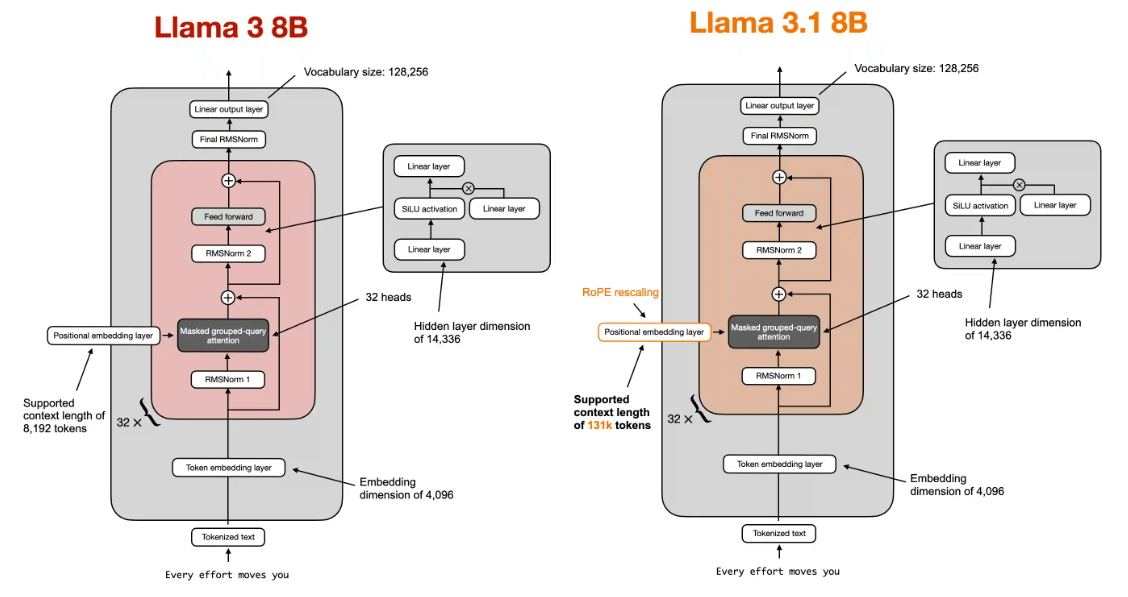


- we can reuse our previous Llama 3 code from above to implement Llama 3.1 8B

The architecture is identical, with the only change being a rescaling of the RoPE frequencies as indicated in the configuration file

In [42]:
LLAMA3_CONFIG_8B = {
    "vocab_size": 128_256,   # Vocabulary size
    "context_length": 8192,  # Context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 14_336,    # Size of the intermediate dimension in FeedForward
    "num_kv_groups": 8,        # Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,  # The base in RoPE's "theta"
    "rope_freq": None,       # Additional configuration for adjusting the RoPE frequencies
    "dtype": torch.bfloat16  # Lower-precision dtype to reduce memory usage
}

LLAMA31_CONFIG_8B = {
    "vocab_size": 128_256,      # Vocabulary size
    "context_length": 131_072,  # NEW: Larger supported context length
    "emb_dim": 4096,            # Embedding dimension
    "n_heads": 32,              # Number of attention heads
    "n_layers": 32,             # Number of layers
    "hidden_dim": 14_336,       # Size of the intermediate dimension in FeedForward
    "num_kv_groups": 8,           # Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,     # The base in RoPE's "theta"
    "dtype": torch.bfloat16,    # Lower-precision dtype to reduce memory usage
    "rope_freq": {              # NEW: RoPE frequency scaling
        "factor": 8.0,
        "low_freq_factor": 1.0,
        "high_freq_factor": 4.0,
        "original_context_length": 8192,
    }
}

- recall that the RoPE method uses sinusoidal functions (sine and cosine) to embed positional information directly into the attention mechanism.

- In Llama 3.1, via the additional configuration, we introduce additional adjustments to the inverse frequency calculations

- These adjustments influence how different frequency components contribute to the positional embeddings (a detailed explanation is a topic for another time)

- Let's try out the Llama 3.1 model:

In [43]:
# free up memory
del model

gc.collect()  # Run Python garbage collector

if torch.cuda.is_available():
    torch.cuda.empty_cache()

- Next, we download the tokenizer

- Note that since the Llama 3.1 family is distinct from the Llama 3 family, you'd have to go to the [meta-llama/Llama-3.1-8B](https://huggingface.co/meta-llama/Llama-3.1-8B) repository and acknowledge the license terms for your Hugging Face access token to work for the download


- For simplicity, we only load the base model below, but there's also an instruction-finetuned version you can use by replacing `"meta-llama/Llama-3.1-8B"` with `"meta-llama/Llama-3.1-8B-Instruct"`

In [44]:
tokenizer_file_path = hf_hub_download(
    repo_id="meta-llama/Llama-3.1-8B",
    filename="original/tokenizer.model",
    local_dir="Llama-3.1-8B"
)

tokenizer = Tokenizer(tokenizer_file_path)

original/tokenizer.model:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

In [45]:
model = Llama3Model(LLAMA31_CONFIG_8B)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 8,030,261,248


In [46]:
combined_weights = {}

for i in range(1, 5):
    weights_file = hf_hub_download(
        repo_id="meta-llama/Llama-3.1-8B",
        filename=f"model-0000{i}-of-00004.safetensors",
        local_dir="Llama-3.1-8B"
    )
    current_weights = load_file(weights_file)
    combined_weights.update(current_weights)

load_weights_into_llama(model, LLAMA31_CONFIG_8B, combined_weights)
model.to(device);
del combined_weights  # free up memory

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

In [47]:
torch.manual_seed(211)

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids("In the midst of winter, ", tokenizer).to(device),
    max_new_tokens=50,
    context_size=LLAMA31_CONFIG_8B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 In the midst of winter, 1 am in a house that was burned. The snow is deeper than my head. I am alone. I have no food. I am cold. I am afraid. I am hungry. I am alone. I am cold. I am afraid.


# Llama 3.2 1B

- Meta AI's latest models are the Llama 3.2 models announced [here](https://ai.meta.com/blog/llama-3-2-connect-2024-vision-edge-mobile-devices/)

- The code for the Llama 3.2 text model is similar to that of Llama 3.1, except that the model has shrunk in size (there is a 1B and 3B version)

- The other efficiency tweak was that they added back weight tying (a concept that was original used in the GPT-2 architecture); here, they reuse the same weight parameter values in the `input (token) embedding layer` and `output layer`

- The small model size of Llama 3.2 1B is quite convenient, since it can even run on many mobile devices

- The architectural differences between Llama 3.1 8B and Llama 3.2 1B are illustrated in the figure below:

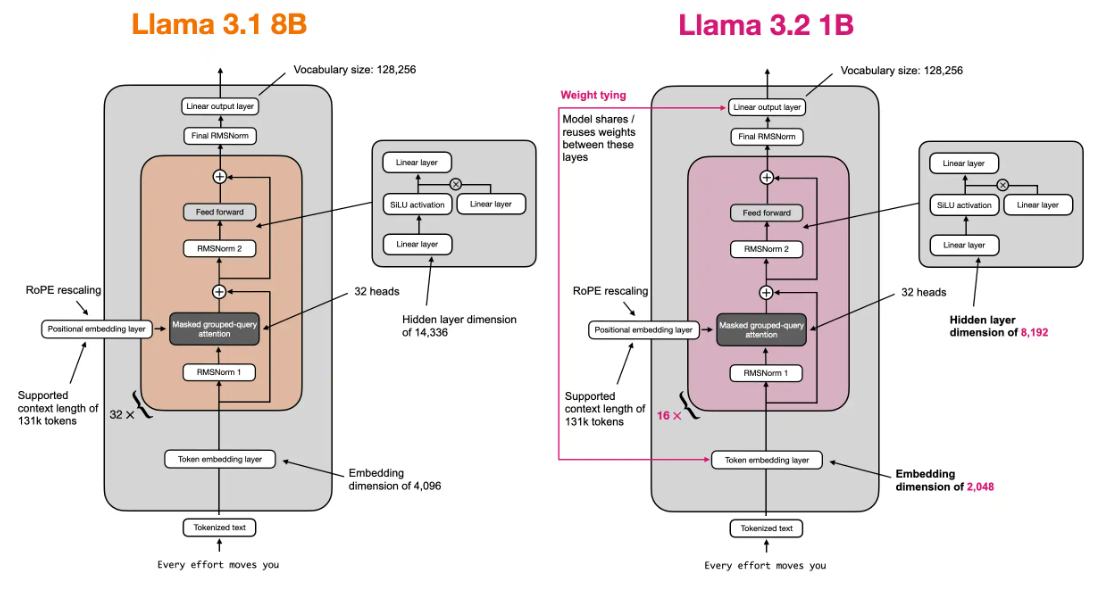


- As we can see based on the figure above, the main difference between the Llama 3.1 8B and Llama 3.2 1B architectures are the respective sizes

- A small additional change is an increased RoPE rescaling factor, which is reflected in the configuration file below

In [48]:
LLAMA31_CONFIG_8B = {
    "vocab_size": 128_256,      # Vocabulary size
    "context_length": 131_072,  # NEW: Larger supported context length
    "emb_dim": 4096,            # Embedding dimension
    "n_heads": 32,              # Number of attention heads
    "n_layers": 32,             # Number of layers
    "hidden_dim": 14_336,       # Size of the intermediate dimension in FeedForward
    "num_kv_groups": 8,           # Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,     # The base in RoPE's "theta"
    "dtype": torch.bfloat16,    # Lower-precision dtype to reduce memory usagey
    "rope_freq": {              # NEW: RoPE frequency scaling
        "factor": 8.0,
        "low_freq_factor": 1.0,
        "high_freq_factor": 4.0,
        "original_context_length": 8192,
    }
}


LLAMA32_CONFIG_1B = {
    "vocab_size": 128_256,      # Vocabulary size
    "context_length": 131_072,  # Context length
    "emb_dim": 2048,            # NEW: Half the embedding dimension
    "n_heads": 32,              # Number of attention heads
    "n_layers": 16,             # NEW: Half the number of layers
    "hidden_dim": 8192,         # NEW: Almost half the size of the intermediate dimension in FeedForward
    "num_kv_groups": 8,           # Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,     # The base in RoPE's "theta"
    "dtype": torch.bfloat16,    # Lower-precision dtype to reduce memory usage
    "rope_freq": {              # RoPE frequency scaling
        "factor": 32.0,         # NEW: Adjustment of the rescaling factor
        "low_freq_factor": 1.0,
        "high_freq_factor": 4.0,
        "original_context_length": 8192,
    }
}

- we can reuse the code from the Llama 3.1 8B section to load the Llama 3.2 1B model

-  since the Llama 3.2 family is distinct from the Llama 3.1 family, you'd have to go to the [meta-llama/Llama-3.2-1B](https://huggingface.co/meta-llama/Llama-3.2-1B) repository and acknowledge the license terms for your Hugging Face access token to work for the download

- For simplicity, we only load the base model below, but there's also an instruction-finetuned version you can use by replacing `"meta-llama/Llama-3.2-1B"` with `"meta-llama/Llama-3.2-1B-Instruct"`

In [49]:
# free up memory
del model


gc.collect()  # Run Python garbage collector

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [50]:
tokenizer_file_path = hf_hub_download(
    repo_id="meta-llama/Llama-3.2-1B",
    filename="original/tokenizer.model",
    local_dir="Llama-3.2-1B"
)

tokenizer = Tokenizer(tokenizer_file_path)

original/tokenizer.model:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

In [51]:
model = Llama3Model(LLAMA32_CONFIG_1B)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

# Account for weight tying
total_params_normalized = total_params - model.token_emb.weight.numel()
print(f"\nTotal number of unique parameters: {total_params_normalized:,}")

Total number of parameters: 1,498,482,688

Total number of unique parameters: 1,235,814,400


In [52]:
weights_file = hf_hub_download(
    repo_id="meta-llama/Llama-3.2-1B",
    filename="model.safetensors",
    local_dir="Llama-3.2-1B"
)
current_weights = load_file(weights_file)

load_weights_into_llama(model, LLAMA32_CONFIG_1B, current_weights)
model.to(device);
del current_weights  # free up memory

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Model uses weight tying.


In [53]:
print("Weight tying:", torch.equal(model.token_emb.weight,
                                   model.out_head.weight))

Weight tying: True


In [54]:
torch.manual_seed(211)

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids("In the midst of winter, ", tokenizer).to(device),
    max_new_tokens=50,
    context_size=LLAMA32_CONFIG_1B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 In the midst of winter, 2012, I was in the midst of a very difficult time. I was in a very dark place. I was in a place where I felt like I was drowning. I was in a place where I felt like I was going to die.


In [55]:
notebook_end_time = time.time()
runtime_in_seconds = notebook_end_time - notebook_start_time

# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"Notebook runtime: {int(minutes)} min {seconds:.2f} sec")
print(f"Device: {device} ")

Notebook runtime: 10 min 43.22 sec
Device: cuda 
